# I Dream My Painting: Exploring the Pipeline

In this notebook, we demonstrate the full pipeline as presented in the paper.

## Setup

### Imports and Reproducibility

In [1]:
import sys
sys.path.append("..")

In [2]:
import os
from pathlib import Path

import lovely_tensors as lt
import torch

from inpainting.data.datasets import InpaintingDataset
from inpainting.models.image_to_text import (
    draw_colored_masks,
    get_pretrained_prompt_generator,
    output_to_color_dict,
)
from inpainting.models.text_to_image import (
    get_freestyle_layout_mask,
    get_freestyle_text_inputs,
    get_pretrained_mm_inpainting_pipe,
)

lt.monkey_patch()

/home/nicola/miniconda3/envs/i-dream-my-painting/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nicola/miniconda3/envs/i-dream-my-painting/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/nicola/miniconda3/envs/i-dream-my-painting/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::fla

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Models

In the next cell, we instantiate the **prompt generator**. Before proceeding, ensure that you have downloaded the `llava-hf/llava-v1.6-vicuna-7b` model from the Hugging Face Hub (it will be downloaded automatically if not already present). Additionally, confirm that you have downloaded the prompt generator weights we provided and placed them in the correct directory.

In [4]:
adapter_path = Path(os.getcwd()).parent / "models" / "llava" / "multimask" / "checkpoint-2884" / "adapter"
prompt_generator_processor, prompt_generator = get_pretrained_prompt_generator(adapter_path)

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


In the next cell, we instantiate the **multi-mask inpainting model**, which utilizes Stable Diffusion 2.0 Inpainting along with our custom **rectified cross-attention** and our LoRA weights for the cross-attention modules. 

Before proceeding, ensure the following:
- You have cloned the `stabilityai/stable-diffusion-2-inpainting` repository into the `models` directory.
- You have correctly modified the `model_index.json` and `unet/config.json` files as instructed in the repository’s README to incorporate our implementation of the model, replacing the default one from `diffusers`.

In [5]:
sd2_path = Path(os.getcwd()).parent / "models" / "stable-diffusion-2-inpainting"
adapter_path = Path(os.getcwd()).parent / "models" / "sd" / "rca" / "checkpoint-2884" / "pytorch_lora_weights.safetensors"
mm_inpainting_pipe = get_pretrained_mm_inpainting_pipe(sd2_path, adapter_path, device)

Loading pipeline components...:  17%|█▋        | 1/6 [00:00<00:01,  3.07it/s]/home/nicola/miniconda3/envs/i-dream-my-painting/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


### Load Dataset

We will use our test set with the settings described in the paper. A demo allowing users to upload their own images and create custom masks is currently in development.

In [6]:
dataset = InpaintingDataset(
    data_dir=Path(os.getcwd()).parent / "data" / "mm_inp_dataset",
    tokenizer=mm_inpainting_pipe.tokenizer,
    max_concepts=5,
    generator=torch.Generator().manual_seed(42),
    shuffle_concepts=True,
    masked_area_threshold=0.65,
    resolution=512,
    freestyle=True,
    drop_caption_probability=0.0,
    texts_dir=None,
    split="test",
)

In the next cell, select an example index between 0 and 4999 to view the pipeline's results for that specific example.

In [7]:
idx = 4001 # you can edit this
example = dataset[idx]
example

{'pixel_values': tensor[3, 512, 512] n=786432 (3Mb) x∈[-1.000, 0.992] μ=-0.051 σ=0.329,
 'masks': tensor[1, 512, 512] n=262144 (1Mb) x∈[0., 1.000] μ=0.425 σ=0.494,
 'freestyle_layout_mask': tensor[6, 512, 512] n=1572864 (6Mb) x∈[0., 1.000] μ=0.432 σ=0.495,
 'input_ids': tensor[77] i64 x∈[0, 49407] μ=4.352e+03 σ=1.015e+04,
 'texts': ['a dirt road with a curved path, bordered by greenery and trees, and theres a hint of a structure or building in the background',
  'a landscape with a mix of green and brown colors, suggesting a natural environment with trees and possibly a hill or mountain in the background'],
 'freestyle_attention_mask': tensor[77] i64 x∈[0, 2] μ=1.026 σ=0.811,
 'masked_pixel_values': tensor[3, 512, 512] n=786432 (3Mb) x∈[-1.000, 0.953] μ=-0.032 σ=0.224,
 'image_stems': 'theodore-robinson_hillside-springtime-giverny',
 'all_masks': [tensor[1, 512, 512] n=262144 (1Mb) x∈[0., 1.000] μ=0.393 σ=0.488,
  tensor[1, 512, 512] n=262144 (1Mb) x∈[0., 1.000] μ=0.048 σ=0.214]}

## Prompt Generation

For prompt generation, we need to apply the colored masks to the image and include the corresponding color names in the input prompt.

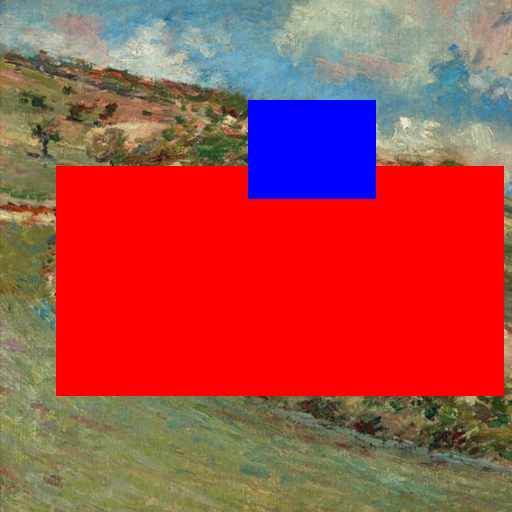

In [8]:
masked_image, color_names = draw_colored_masks(example["pixel_values"], example["all_masks"])
masked_image

In [9]:
prompt = f"A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>\nDiscover and describe the objects hidden behind the masks of the colors: {', '.join(color_names)}. ASSISTANT:"
prompt

"A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>\nDiscover and describe the objects hidden behind the masks of the colors: red, blue. ASSISTANT:"

In the next cell, we generate a prompt using the fine-tuned LLaVA model. For more creative outcomes, we opt to use sampling with a mean temperature value. Note that all results presented in the paper (except for the temperature ablation) were generated **without** sampling, using greedy decoding.

In [10]:
inputs = prompt_generator_processor(prompt, masked_image, return_tensors="pt").to(device)

# autoregressively complete prompt
output = prompt_generator.generate(**inputs, max_new_tokens=512, do_sample=True, temperature=0.5)
output = prompt_generator_processor.decode(output[0], skip_special_tokens=True)
output

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


"A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: \nDiscover and describe the objects hidden behind the masks of the colors: red, blue. ASSISTANT: <red>a dirt road with a mix of greenery and a hint of a structure or building on the left side</red><blue>a house with a prominent chimney, set against a backdrop of a sky with clouds</blue>"

We transform the output into a dictionary:

In [11]:
color_output = output_to_color_dict(output, color_names)
color_output

{'red': 'a dirt road with a mix of greenery and a hint of a structure or building on the left side',
 'blue': 'a house with a prominent chimney, set against a backdrop of a sky with clouds'}

## Multi-Mask Inpainting

For multi-mask inpainting, we combine the individual prompts into a single prompt, adhering to the maximum token limit. Since multiple prompts may exceed this limit, we truncate each one individually to ensure the total number of tokens stays within bounds without disproportionately penalizing any specific prompt.

Multi-mask inpainting with RCA requires a binary layout mask, which consists of all the masks to be inpainted in a binary format. Additionally, it includes an all-ones mask at the start, allowing tokens to attend to the entire image, and a token mask that defines the relationships between the masks and tokens.

In [12]:
freestyle_layout_mask = get_freestyle_layout_mask(example["all_masks"], max_concepts=5)
freestyle_layout_mask

tensor[6, 512, 512] n=1572864 (6Mb) x∈[0., 1.000] μ=0.432 σ=0.495

In [13]:
input_ids, freestyle_attention_mask = get_freestyle_text_inputs(list(color_output.values()), mm_inpainting_pipe.tokenizer)
input_ids, freestyle_attention_mask

(tensor[77] i64 x∈[0, 49407] μ=3.485e+03 σ=1.004e+04,
 tensor[77] i64 x∈[0, 2] μ=0.675 σ=0.802)

/home/nicola/miniconda3/envs/i-dream-my-painting/lib/python3.12/site-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.9921568632125854]
  warnings.warn(
100%|██████████| 50/50 [00:02<00:00, 24.93it/s]


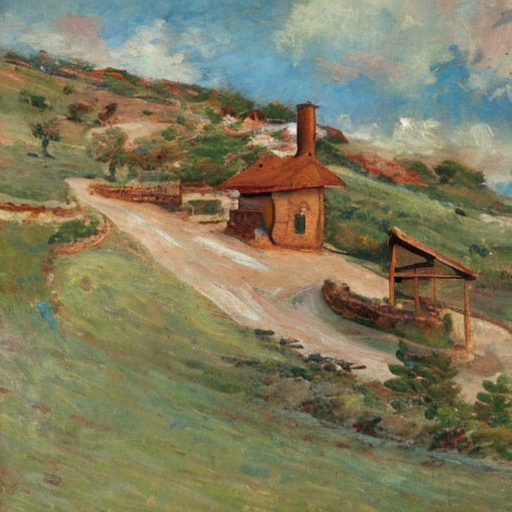

In [14]:
inpainted = mm_inpainting_pipe(
    input_ids=input_ids.unsqueeze(0).to(device),
    freestyle_attention_mask=freestyle_attention_mask.unsqueeze(0).to(device),
    freestyle_layout_mask=freestyle_layout_mask.unsqueeze(0).to(device),
    image=example["pixel_values"],
    mask_image=example["masks"],
)
inpainted.images[0]